In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch==1.13.1
!pip install torchvision==0.14.1

!pip install -r /content/drive/MyDrive/CavoT/CvT/requirements.txt
!pip install -r /content/drive/MyDrive/CavoT/pytorch-grad-cam/requirements.txt
!pip install iopath
!pip install pyyaml
!pip install einops
!pip install timm
!pip install yacs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.13.1 which

In [3]:
import importlib.util
import sys
from google.colab import drive
from iopath.common.file_io import g_pathmgr as pathmgr
import yaml
from yacs.config import CfgNode as CN
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')

# To add a directory with your code into a list of directories
# which will be searched for packages
sys.path.append('/content/drive/MyDrive/CavoT/CvT/lib/models/')
# import cls_cvt
from cls_cvt import get_cls_model

sys.path.append('/content/drive/MyDrive/CavoT/pytorch-grad-cam/')

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Helper Functions
def load_model(model, model_path):
  with pathmgr.open(model_path, "rb") as f:
    checkpoint = torch.load(f, map_location="cuda")
    model.load_state_dict(checkpoint["model"])

In [5]:
#Load Model
# path_to_yaml = '/content/drive/MyDrive/CavoT/CvT/experiments/imagenet/cvt/cvt-21-384x384.yaml'
# path_to_checkpoint = '/content/drive/MyDrive/CavoT/pretrained_models/CvT-21-384x384-IN-1k.pth'
path_to_yaml = '/content/drive/MyDrive/CavoT/CvT/experiments/imagenet/cvt/cvt-13-224x224.yaml'
path_to_checkpoint = '/content/drive/MyDrive/CavoT/pretrained_models/CvT-13-224x224-IN-1k.pth'

def load_config(path_to_yaml, pretrained=False, pretrained_layers=[], num_classes=1000):
  _C = CN()
  # Allow creating new keys recursively.
  _C.set_new_allowed(True)
  _C.merge_from_file(path_to_yaml)
  _C.MODEL.NUM_CLASSES = num_classes
  _C.MODEL.INIT_WEIGHTS = True
  _C.MODEL.PRETRAINED = pretrained
  _C.MODEL.PRETRAINED_LAYERS = pretrained_layers
  _C.VERBOSE = False
  return _C

config = load_config(path_to_yaml, pretrained=path_to_checkpoint, pretrained_layers=['*'], num_classes=1000)
model = get_cls_model(config).to('cuda')

In [6]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

from PIL import Image
input_image = Image.open(filename)
input_image = input_image.resize((224, 224), Image.LANCZOS)
input_tensor = preprocess_image(input_image).to('cuda')
rgb_image = np.float32(input_image) / 255

In [7]:
# CvT Grad-Cam Visualization
target_layers = [model.stage2.blocks[0]]

# Construct the CAM object once, and then re-use it on many images:
cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(999)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
print('input_tensor.shape: ', input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

input_tensor.shape:  torch.Size([1, 3, 224, 224])
outputs.shape before unqueeze:  torch.Size([1000])
outputs.shape after unsqueze:  torch.Size([1, 1000])


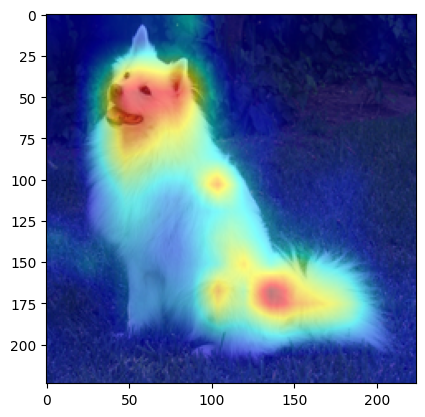

In [8]:
plt.imshow(visualization)

In [30]:
# ResNet Grad-Cam Visualization
from torchvision.models import resnet50

model = resnet50(pretrained=True).to('cuda')
target_layers = [model.layer4[-1]]

# Construct the CAM object once, and then re-use it on many images:
cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(999)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

outputs.shape before unqueeze:  torch.Size([1, 1000])


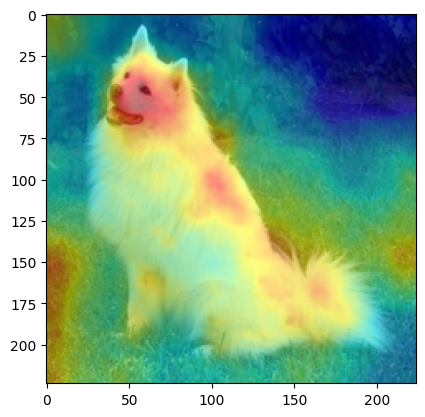

In [31]:
plt.imshow(visualization)